In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:
df = pd.read_csv('cleaned_hospital.csv')

## Start with Linear Regression

We chose to begin with a **linear regression model** for predicting the mean cost of hospital discharges because:

- **Baseline Simplicity:**  
  It allows us to understand whether simple linear relationships between features.

- **Interpretability:**  
  Coefficients in linear regression are highly interpretable. 

- **Computational Efficiency:**  
  Linear regression is fast to train, even on large datasets like this with 1M observations.


In [ ]:
# Prepare feature set
feature_cols = ['Year', 'Facility Id', 'APR DRG Code', 'APR Severity of Illness Code', 'APR Medical Surgical Code']
X = df[feature_cols]
y = df['log_mean_cost']

# One-hot encode categorical features
X = pd.get_dummies(X, columns=['Facility Id', 'APR DRG Code', 'APR Medical Surgical Code'])

# Initialize model and cross-validator
lr_model = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics
rmse_log_list, mae_log_list, r2_log_list = [], [], []
rmse_original_list, mae_original_list, r2_original_list = [], [], []

# List to store fold results for table
fold_results = []

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    lr_model.fit(X_train, y_train)
    y_val_pred_log = lr_model.predict(X_val)

    # Log scale metrics
    mse_log = mean_squared_error(y_val, y_val_pred_log)
    rmse_log = np.sqrt(mse_log)
    mae_log = mean_absolute_error(y_val, y_val_pred_log)
    r2_log = r2_score(y_val, y_val_pred_log)

    # Save log metrics
    rmse_log_list.append(rmse_log)
    mae_log_list.append(mae_log)
    r2_log_list.append(r2_log)

    # Original scale metrics
    y_val_pred_original = np.expm1(y_val_pred_log)
    y_val_original = np.expm1(y_val)

    mse_original = mean_squared_error(y_val_original, y_val_pred_original)
    rmse_original = np.sqrt(mse_original)
    mae_original = mean_absolute_error(y_val_original, y_val_pred_original)
    r2_original = r2_score(y_val_original, y_val_pred_original)

    # Save original metrics
    rmse_original_list.append(rmse_original)
    mae_original_list.append(mae_original)
    r2_original_list.append(r2_original)

    # Save results to table
    fold_results.append({
        'Fold': fold,
        'RMSE (log)': rmse_log,
        'MAE (log)': mae_log,
        'R² (log)': r2_log,
        'RMSE (original)': rmse_original,
        'MAE (original)': mae_original,
        'R² (original)': r2_original
    })

# Create a DataFrame
results_df = pd.DataFrame(fold_results)

# Round for nicer printing
results_df_rounded = results_df.round({
    'RMSE (log)': 4,
    'MAE (log)': 4,
    'R² (log)': 4,
    'RMSE (original)': 2,
    'MAE (original)': 2,
    'R² (original)': 4
})

In [9]:
# Print the table
print("\nCross-Validation Fold Results:")
print("=" * 80)
print(results_df_rounded)

# Average and Std metrics across folds
print("\nOverall Cross-Validation Summary:")
print("=" * 80)
print("(log scale):")
print(f"Mean RMSE: {np.mean(rmse_log_list):.4f} ± {np.std(rmse_log_list):.4f}")
print(f"Mean MAE: {np.mean(mae_log_list):.4f} ± {np.std(mae_log_list):.4f}")
print(f"Mean R²: {np.mean(r2_log_list):.4f} ± {np.std(r2_log_list):.4f}")
print("-" * 80)
print("(original scale):")
print(f"Mean RMSE: {np.mean(rmse_original_list):.2f} ± {np.std(rmse_original_list):.2f}")
print(f"Mean MAE: {np.mean(mae_original_list):.2f} ± {np.std(mae_original_list):.2f}")
print(f"Mean R²: {np.mean(r2_original_list):.4f} ± {np.std(r2_original_list):.4f}")


Cross-Validation Fold Results:
   Fold  RMSE (log)  MAE (log)  R² (log)  RMSE (original)  MAE (original)  \
0     1      0.5193     0.3721    0.7099         29109.60         7609.63   
1     2      0.5167     0.3712    0.7132         28238.76         7654.07   
2     3      0.5173     0.3711    0.7119         24118.49         7566.47   
3     4      0.5193     0.3730    0.7084         25736.98         7602.35   
4     5      0.5177     0.3711    0.7100         25192.13         7564.60   

   R² (original)  
0         0.3788  
1         0.3925  
2         0.4681  
3         0.4432  
4         0.4440  

Overall Cross-Validation Summary:
(log scale):
Mean RMSE: 0.5181 ± 0.0011
Mean MAE: 0.3717 ± 0.0007
Mean R²: 0.7107 ± 0.0017
--------------------------------------------------------------------------------
(original scale):
Mean RMSE: 26479.19 ± 1886.56
Mean MAE: 7599.42 ± 32.86
Mean R²: 0.4253 ± 0.0339


## Model Evaluation Summary

Across 5-fold cross-validation, **Fold 3** achieved the best performance with the lowest RMSE (**24,118.49**) and the highest R² (**0.4681**) on the original cost scale.

Overall, the linear regression model demonstrated an **acceptable predictive performance** on the log-transformed mean costs (average R² ≈ **0.71**), but showed **low explanatory power** on the original cost scale (average R² ≈ **0.42**).

In [ ]:
# Get Fold 3 train/val indices
train_idx, val_idx = list(kf.split(X))[2] 

X_train_fold3, X_val_fold3 = X.iloc[train_idx], X.iloc[val_idx]
y_train_fold3, y_val_fold3 = y.iloc[train_idx], y.iloc[val_idx]

# Train on Fold 3
lr_model.fit(X_train_fold3, y_train_fold3)
y_val_pred_log_fold3 = lr_model.predict(X_val_fold3)

# Convert back to original scale
y_val_pred_original_fold3 = np.expm1(y_val_pred_log_fold3)
y_val_original_fold3 = np.expm1(y_val_fold3)

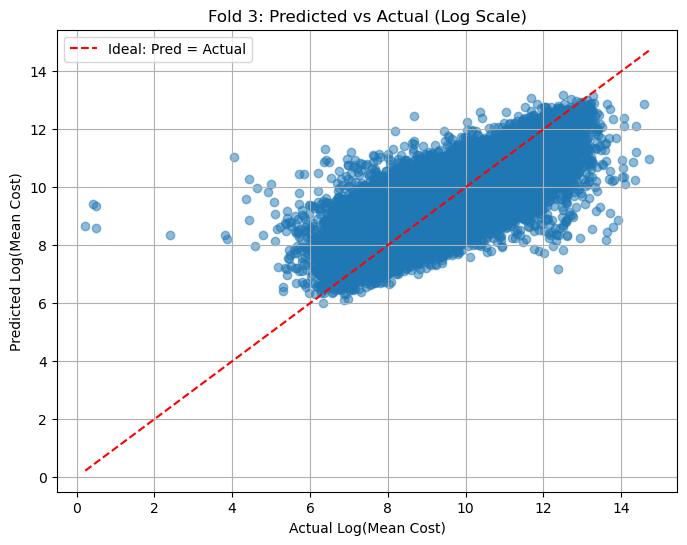

In [ ]:
# Plot Predicted vs Actual on Log Scale
plt.figure(figsize=(8,6))
plt.scatter(y_val_fold3, y_val_pred_log_fold3, alpha=0.5)
plt.plot([y_val_fold3.min(), y_val_fold3.max()],
         [y_val_fold3.min(), y_val_fold3.max()],
         'r--', label='Ideal: Pred = Actual')
plt.xlabel('Actual Log(Mean Cost)')
plt.ylabel('Predicted Log(Mean Cost)')
plt.title('Fold 3: Predicted vs Actual (Log Scale)')
plt.grid(True)
plt.legend()
plt.show()

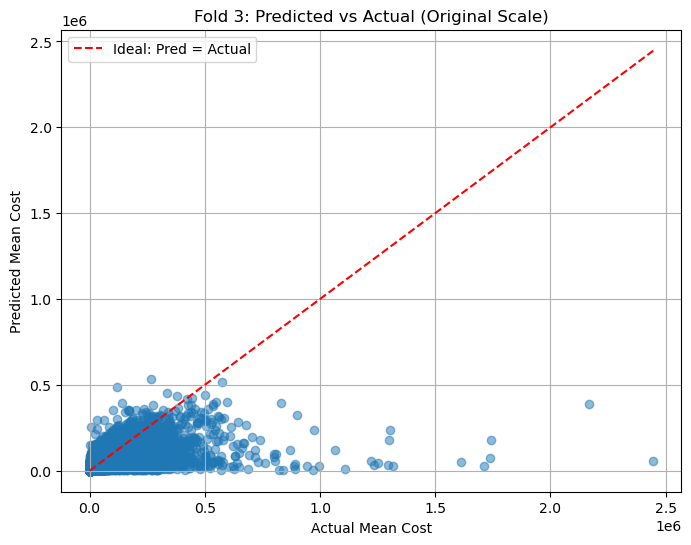

In [6]:
# Plot Predicted vs Actual
plt.figure(figsize=(8,6))
plt.scatter(y_val_original_fold3, y_val_pred_original_fold3, alpha=0.5)
plt.plot([y_val_original_fold3.min(), y_val_original_fold3.max()],
         [y_val_original_fold3.min(), y_val_original_fold3.max()],
         'r--', label='Ideal: Pred = Actual')
plt.xlabel('Actual Mean Cost')
plt.ylabel('Predicted Mean Cost')
plt.title('Fold 3: Predicted vs Actual (Original Scale)')
plt.grid(True)
plt.legend()
plt.show()

## Model Performance Plot Analysis

- Most points are clustered near the diagonal, indicating that the linear regression model captured the overall trend. 
- There are huge dispersion around the ideal line, which indicates the model is underfitting. 
- The model performs poorly for high-cost discharges, underestimating large values. 

This pattern indicates that the relationship between features and cost is non-linear and more complex.

## Next Step: Decision Tree Regressor
